In [13]:
import cv2 as cv
import numpy as np
import pandas as pd
from glob import glob
from sklearn.utils import shuffle

from config import efficientNet_config
from models import efficientNetV2B0_model, efficientNetV2B3_model, vgg16_model, resnet50_model
from utils import plt_heatmap, plt_roccurve

from sklearn.metrics import confusion_matrix
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import roc_curve, auc, accuracy_score, f1_score
from sklearn.preprocessing import OneHotEncoder

import os
# 使用第一張 GPU 卡
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

# 載入模型

In [14]:
model = efficientNetV2B0_model()  # 類別
model.load_weights('../model/202303/20230410.weights')

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-b0 (Function  (None, 1280)             5919312   
 al)                                                             
                                                                 
 dense_1 (Dense)             (None, 1)                 1281      
                                                                 
Total params: 5,920,593
Trainable params: 5,859,985
Non-trainable params: 60,608
_________________________________________________________________


In [15]:
height  = efficientNet_config['height_B0']
width   = efficientNet_config['width_B0']

# 法一: 分類模型 測試集結果

In [16]:
test_img_paths     = sorted(glob('../../classification/dataset_186video_20230323/test/1/*.png'))                  # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! 換資料集

test_imgnames = []
test_img_arrays = []
test_img_labels = []

## up
for test_img_path in test_img_paths:
    imgname = test_img_path.split("/")[-1]
    test_imgnames.append(imgname)

    img_array = cv.imread(test_img_path)
    img_array = cv.resize(img_array,(224, 224))     # efficientNetv2B0
    
    # image array
    test_img_arrays.append(img_array)
    # label
    test_img_labels.append([0])

## down
for test_img_path in test_img_paths:
    img_array = cv.imread(test_img_path)
    img_array = cv.resize(img_array,(224, 224))     # efficientNetv2B0
    smoothed_img2_ROTATE_180 = cv.rotate(img_array, cv.ROTATE_180)   # 轉180度
    # image array(rotate 180) 
    test_img_arrays.append(smoothed_img2_ROTATE_180)
    # label(rotate 180)
    test_img_labels.append([1])


# to numpy array
test_img_arrays = np.array(test_img_arrays)
test_img_labels = np.array(test_img_labels)

# 打亂

In [17]:
# tes_img_arrays, tes_img_labels = shuffle(tes_img_arrays, tes_img_labels)

In [18]:
# tes_img_arrays.shape

# 預測

In [19]:
pred_result = model.predict(test_img_arrays)

2023-07-07 11:24:54.676566: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 438036480 exceeds 10% of free system memory.
2023-07-07 11:24:54.994399: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 438036480 exceeds 10% of free system memory.


91/91 [==============================] - 3s 24ms/step


# 結果

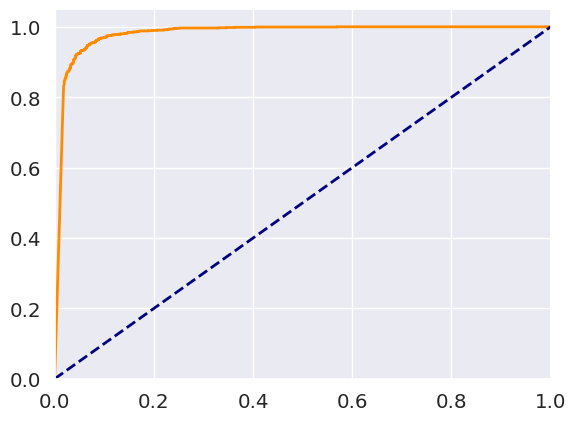

AUROC= 0.9809281893222801


In [20]:
fpr, tpr, thresholds = roc_curve(test_img_labels, pred_result, pos_label=1) 
roc_auc = auc(fpr, tpr)
plt_roccurve(fpr,tpr,roc_auc)
print("AUROC=",roc_auc)

In [21]:
pred_result = np.where(pred_result > 0.5, 1,0)
tn, fp, fn, tp = confusion_matrix(test_img_labels, pred_result).ravel()
sensitivity = round(tp / (tp+fn), 4)
specificity = round(tn / (tn+fp), 4)
balanced_acc= round((sensitivity+specificity)/2, 4)
precision   = round(tp / (tp+fp), 4)
f1score     = round(2/((1/precision)+(1/sensitivity)), 4)
accuracy    = round((tp+tn)/(tn+fp+fn+tp), 4)

print('Sensitivity= ',sensitivity)
print('Specificity= ',specificity)
print('Balanced_acc= ',balanced_acc)
print('Precision= ', precision)
print('f1score= ', f1score)
print('Accuracy= ',accuracy)

Sensitivity=  0.9388
Specificity=  0.9368
Balanced_acc=  0.9378
Precision=  0.9369
f1score=  0.9378
Accuracy=  0.9378


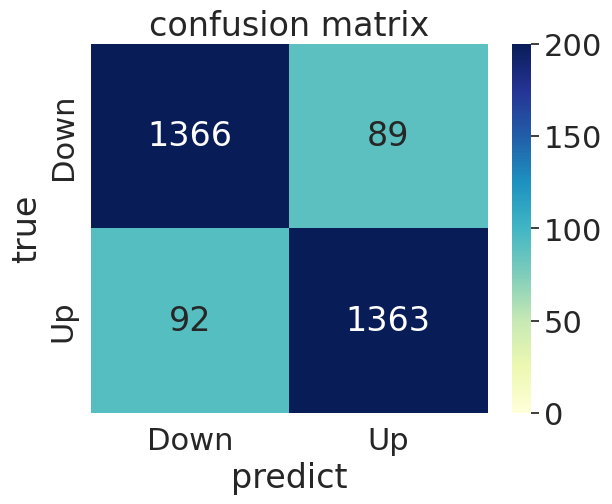

In [22]:
plt_heatmap([[tp,fn],[fp,tn]])

In [23]:
# 將結果存起來，給stage3用

# test_dict = {
#  "test_name" : test_imgnames,
#  "test_true" : test_img_labels.reshape(-1)[:(len(test_img_labels)//2)],     # 先只存左上的結果
#  "stage3_updown_test_pred" : pred_result.reshape(-1)[:(len(pred_result)//2)]
# }

# pd.DataFrame(test_dict).to_pickle("../result/stage3_updown_pred_result_test_20230401_AllImg.pickle")


In [24]:
# count = 0
# for i in pred_result.reshape(-1)[:(len(pred_result)//2)]:
#     if i == 1:
#         count+=1

# count